#**NPL HOMEWORK PART 2**
Manfè Alessandro\
2041603


---


Purpose of this project is to implement a neural based dependency parsing network using Arc Eager algorithm.\
The models we'll see are a slightly modified version of the BiLSTM model presented in class adapted to work with Arc Eager.



Dependencies:

In [ ]:
!pip install datasets  # huggingface library with dataset
!pip install conllu    # aux library for processing CoNLL-U format
!pip install evaluate
!pip install accelerate
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 25.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [ ]:
import torch
import torch.nn as nn
from functools import partial
from datasets import load_dataset
from matplotlib import pyplot as plt
import numpy as np



---


#Section 1: Dataset


---






For the purpose of this project a dependency treebank is required. \
Common choice is to utilize Universal Dependency's treebanks as they're free, available in several languages and include sources of various kinds (like academic, news, spoken languages and more).
Unfortunately little to no paper and leaderboard presents performance evaluation on mono-language treebank and *Section 5* of this project requires us to compare our result to the current SotA model performance on the dataset of our own choice.\
Even worse than that almost all treebanks used in those papers are not free to the public or they're really difficult to obtain.\
I was not able to find a feasible dataset in the leaderboards (mono-language), but with a little bit of search i stumble upon this paper: \

 https://arxiv.org/pdf/2012.13163.pdf \

 which includes, among others, also a performance score for Universal Dependency Treebank English (mono-language) **EWT**.
 This dataset contains text from: blog, emails, reviews, social network and web in general.
 We're going to give it a try and also attempt a comparison with the multilingual models.



In [ ]:
dataset = load_dataset('universal_dependencies', 'en_ewt')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/12543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2077 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_ewt/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 12543
    })
    validation: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 2002
    })
    test: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 2077
    })
})


As we can see this treebank includes the following samples:


*   12543 for the training set
*   2002  for the validation set
*   2007  for the test set

In total we have
*   16622 sentences
*   251487 tokens
*   254819 syntactic words.

Other specifications can be found on the documentation page:
https://universaldependencies.org/treebanks/en_ewt/index.html

Let's see a sample from this dataset:

In [ ]:
sample = dataset["train"][42]
print(sample)
print("\nTokens:\t", sample["tokens"])
print("Gold:\t", sample["head"])

{'idx': 'weblog-blogspot.com_healingiraq_20040409053012_ENG_20040409_053012-0003', 'text': 'There has been talk that the night curfew might be implemented again.', 'tokens': ['There', 'has', 'been', 'talk', 'that', 'the', 'night', 'curfew', 'might', 'be', 'implemented', 'again', '.'], 'lemmas': ['there', 'have', 'be', 'talk', 'that', 'the', 'night', 'curfew', 'might', 'be', 'implement', 'again', '.'], 'upos': [11, 17, 16, 0, 5, 8, 0, 0, 17, 17, 16, 14, 1], 'xpos': ['EX', 'VBZ', 'VBN', 'NN', 'IN', 'DT', 'NN', 'NN', 'MD', 'VB', 'VBN', 'RB', '.'], 'feats': ['None', "{'Mood': 'Ind', 'Number': 'Sing', 'Person': '3', 'Tense': 'Pres', 'VerbForm': 'Fin'}", "{'Tense': 'Past', 'VerbForm': 'Part'}", "{'Number': 'Sing'}", 'None', "{'Definite': 'Def', 'PronType': 'Art'}", "{'Number': 'Sing'}", "{'Number': 'Sing'}", "{'VerbForm': 'Fin'}", "{'VerbForm': 'Inf'}", "{'Tense': 'Past', 'VerbForm': 'Part'}", 'None', 'None'], 'head': ['3', '3', '0', '3', '11', '8', '8', '11', '11', '11', '4', '11', '4'], 'd

For the sake of completeness we'll also plotting phrases lenght distribution:

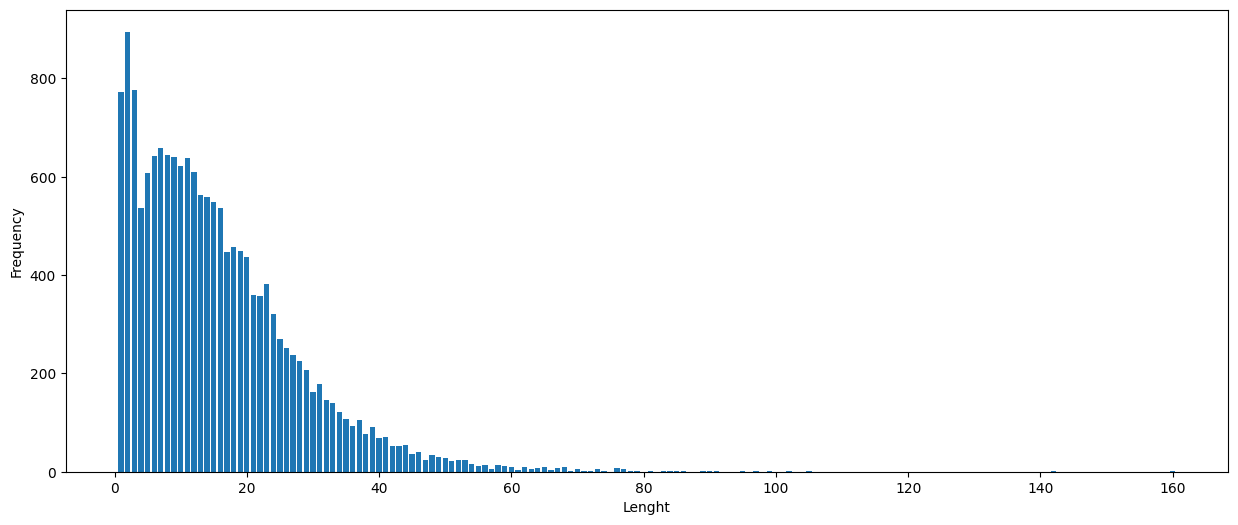

In [ ]:
hist = {}
for k in dataset.keys():
  for sample in dataset[k]["tokens"]:
    if len(sample) not in hist:
      hist[len(sample)] = 0
    hist[len(sample)] += 1

data = np.array([i for i in sorted(hist.items(), key=lambda x: x[0])]).transpose()

plt.figure(figsize=(15,6))
plt.bar(data[0],data[1],align='center', width=0.8) # A bar chart
plt.xlabel('Lenght')
plt.ylabel('Frequency')
plt.show()



---
#Section 2: Description of Models


---

 \

Both BiLSTM and BERT-based models follow what was defined in lab classes.\
Main difference is given by having to adapt the ArcEager model instead of the Standard parser. \




## ArcEager

A **configuration** of the arcEager parser is a triple of the form $( \sigma, \beta, A)$
where:

* $\sigma$ is the stack;
* $\beta$ is the input buffer;
* $A$ is a set of arcs constructed so far.

We write $\sigma_i$, $i \geq 1$, for the $i$-th token in the stack; we also write $\beta_i$, $i \geq 1$, for the $i$-th token in the buffer.

The parser can perform three types of **actions** (transitions):

* **shift**, which removes $\beta_1$ from the buffer and pushes it into the stack;
* **left-arc**, which creates the arc $(\beta_1 \rightarrow \sigma_1)$, and removes $\sigma_1$ from the stack;
* **right-arc**, which creates the arc $(\sigma_1 \rightarrow \beta_1)$, and pushes $\beta_1$ into the stack.
* **reduce**, which removes $\sigma_1$ from the stack.

Let $w = w_0 w_1 \cdots w_{n}$ be the input sentence, with $w_0$ the special symbol `<ROOT>`.
Stack and buffer are implemented as lists of integers, where `j` represents word $w_j$.  Top-most stack token is at the right-end of the list; first buffer token is at the left-end of the list.
Set $A$ is implemented as an array `arcs` of size $n+1$ such that if arc $(w_i \rightarrow w_j)$ is in $A$ then `arcs[j]=i`, and if $w_j$ is still missing its head node in the tree under construction, then `arcs[j]=-1`. We always have `arcs[0]=-1`.  We use this representation also for complete dependency trees.

Final condition is reched for any configuration $( \sigma, \beta, A)$ such that the buffer $\beta$ is empty.

Let's see the implementation of the parser:

In [ ]:
class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    #two shift moves to initialize the stack (one for the root)
    self.shift()
    self.shift()

  def shift(self):
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]
    self.stack.append(b1)

  def left_arc(self):
    s = self.stack.pop()
    b = self.buffer[0]
    self.arcs[s] = b
    if len(self.stack) < 1 and len(self.buffer) > 0:
      self.shift()

  def right_arc(self):
    s = self.stack[-1]
    b = self.buffer[0]
    self.arcs[b] = s
    self.shift()
    if len(self.stack) < 1 and len(self.buffer) > 0:
      self.shift()

  def reduce(self):
    self.stack.pop()

  def is_tree_final(self):
    return len(self.buffer) == 0

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

## Oracle

This that a **static oracle** maps parser configurations $c$ into  actions, and it does so by looking into the gold (reference) tree for the sentence at hand.  If $c$ does not contain any mistake, then the action provided by the oracle for $c$ is guaranted to be correct.  Furthermore, in cases where there is more than one correct action for $c$, the oracle always chooses a single action, called the **canonical** action.

The static oracle for the ArcEager parseris based on the following conditions:
* set $A$ in configuration $c$ does not contain any wrong dependency
* left-arc has precedence over other actions, and has a precondition that the top of the stack is not the artificial root node 0 and does not already
have a head.

* right-arc can be done only if it constructs a gold dependency and has not other precondition other than the preference order.
* reduce transition is subject to the preconditions that the top stack token has a head.

* shift transition has lowest precedence, and can be done if the buffer is not empty

In [ ]:
class StaticArcEagerOracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    s = self.parser.stack[-1]
    b = self.parser.buffer[0]

    if self.gold[s] == b:
      return True

    return False

  def is_right_arc_gold(self):
    s = self.parser.stack[-1]
    b = self.parser.buffer[0]

    if self.gold[b] == s:
      return True

    return False

  def is_reduce_gold(self):
    s = self.parser.stack[-1]
    b = self.parser.buffer[0]
    for k in range(s):
      if self.gold[k] == b or self.gold[b] == k:
        return True
    return False


  def is_shift_gold(self):
    #This dictates transition precedence of the parser
    if (self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold()):
      return False

    return True

#BiLSTM model

Main differences are:
* change of the shape of configuration, which now includes only the top
tokens of buffer and stack $[\beta_1,\sigma_1]$ (if $\sigma_1$ exists otherwise '-1')
* consequent change of MLP layer size
* condition in parse_step function (which were not implemented in the parser class)

Let's see the implementation (very similar to the one seen in class):

In [ ]:
EMBEDDING_SIZE = 200
LSTM_SIZE = 200
LSTM_LAYERS = 1
MLP_SIZE = 200
DROPOUT = 0.2

class BiLSTMBasedModel(nn.Module):

  def __init__(self, device):
    super(BiLSTMBasedModel, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(4*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i],
                                    zero_tensor if j[1]==-1 else h[j[1]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves- For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        if moves_argm[i] == 0:
          if parsers[i].stack[-1] != 0:
            parsers[i].left_arc()
          else:
            parsers[i].right_arc()
        elif moves_argm[i] == 1:
          parsers[i].right_arc()
        elif moves_argm[i] == 2:
          if parsers[i].stack[-1] == 0:
            parsers[i].shift()
          else:
            parsers[i].reduce()
        elif moves_argm[i] == 3:
          parsers[i].shift()



#BERT model

For the BERT based model, besides all previous consideration and other small tweakings, the following 2 main changes have been applied: \
* BERT-base model comes pre-trained with its own embedding dictionary of approximately 30000 tokens (words, sub-words, ecc...),
so we need to apply a specific tokenization and embedding process in data preprocessing (see *Section 3*), so we removed the embedding layer here.

* Output choice: BERT's output can be used in different ways. Usually for classification tasks only the last hidden layer is taken and then passed by a feed forward network. In other cases it's suggested to take the average or a pool of the layers for better results. **We decide to take the average of last 5 layers as out output.**




In [ ]:
from transformers import AutoTokenizer, AutoModel

model_name = "bert-base-uncased"

bert_model = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
MLP_SIZE = 200
BERT_SIZE = 768
DROPOUT = 0.1

class BERTBasedModel(nn.Module):

    def __init__(self, device):
      super(BERTBasedModel, self).__init__()
      self.device = device

      # initialize BERT
      self.bert = bert_model

      # initialize feedforward
      self.w1 = torch.nn.Linear(2*BERT_SIZE, MLP_SIZE, bias=True)
      self.activation = torch.nn.Tanh()
      self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
      self.softmax = torch.nn.Softmax(dim=-1)

      self.dropout = torch.nn.Dropout(DROPOUT)


    def forward(self, x, attention, paths):

      #run bert
      output = self.bert(input_ids = x.to(self.device), attention_mask = attention.to(self.device), output_hidden_states=True)

      #select hidden states (embedding + 12 layer) from output
      hs = output["hidden_states"]

      #take the average of last 5 layer and apply dropout
      hs = torch.stack(hs[-5:]).to(self.device)
      hs = torch.mean(hs, dim=0)
      h = self.dropout(hs).to(self.device)

      # for each parser configuration that we need to score we arrange from the
      # output of the bert the correct input for the feedforward
      mlp_input = self.get_mlp_input(paths, h)

      # run the feedforward and get the scores for each possible action
      out = self.mlp(mlp_input)

      return out


    def get_mlp_input(self, configurations, h):
      mlp_input = []
      zero_tensor = torch.zeros(BERT_SIZE, requires_grad=False).to(self.device)
      for i in range(len(configurations)): # for every sentence in the batch
        for j in configurations[i]: # for each configuration of a sentence
          mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[i][j[0]],
                                      zero_tensor if j[1]==-1 else h[i][j[1]]]))
      mlp_input = torch.stack(mlp_input).to(self.device)
      return mlp_input


    def mlp(self, x):
      return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

    # we use this function at inference time. We run the parser and at each step
    # we pick as next move the one with the highest score assigned by the model
    def infere(self, x, attention, sentences):

      parsers = [ArcEager(i) for i in sentences]

      output = self.bert(input_ids = x.to(self.device), attention_mask = attention.to(self.device), output_hidden_states=True)

      #select hidden states (embedding + 12 layer) from output
      hs = output["hidden_states"]

      #take the average of last 5 layer
      hs = torch.stack(hs[-5:]).to(self.device)
      h = torch.mean(hs, dim=0).to(self.device)

      while not self.parsed_all(parsers):
        # get the current configuration and score next moves
        configurations = self.get_configurations(parsers)
        mlp_input = self.get_mlp_input(configurations, h)
        mlp_out = self.mlp(mlp_input)
        # take the next parsing step
        self.parse_step(parsers, mlp_out)

      # return the predicted dependency tree
      return [parser.arcs for parser in parsers]

    def get_configurations(self, parsers):
      configurations = []

      for parser in parsers:
        if parser.is_tree_final():
          conf = [-1, -1]
        else:
          conf = [parser.stack[len(parser.stack)-1]]
          if len(parser.buffer) == 0:
            conf.append(-1)
          else:
            conf.append(parser.buffer[0])
        configurations.append([conf])

      return configurations

    def parsed_all(self, parsers):
      for parser in parsers:
        if not parser.is_tree_final():
          return False
      return True

    # In this function we select and perform the next move according to the scores obtained.
    # We need to be careful and select correct moves. For clarity sake we didn't implement
    # these checks in the parser so we must do them here. This renders the function quite ugly
    def parse_step(self, parsers, moves):
      moves_argm = moves.argmax(-1)
      for i in range(len(parsers)):
        if parsers[i].is_tree_final():
          continue
        else:
          if moves_argm[i] == 0:
            if parsers[i].stack[-1] != 0:
              parsers[i].left_arc()
            else:
              parsers[i].right_arc()
          elif moves_argm[i] == 1:
            parsers[i].right_arc()
          elif moves_argm[i] == 2:
            if parsers[i].stack[-1] == 0:
              parsers[i].shift()
            else:
              parsers[i].reduce()
          elif moves_argm[i] == 3:
            parsers[i].shift()



---

#Section 3: Data setup and Training

---



In this section we need to take two different routes to process the dataset. \
For the BiLSTM model it's straightforward as we seen in lab. \
BERT instead needs the input to be padded to a fixed lenght and paired with the **attention mask**. \
Padding can be done dataset-wise or batch-wise which is more convenient as the size of each sample is adapted to the longest sample in the batch.
We also need to provide an attention mask which tells BERT which of the token we're passing in input are actually useful token or just padding. \
 \
 \
Since ArcEager is functional only on projective sentences we need to filter the dataset to keep only the useful samples:

In [ ]:
# the function returns whether a tree is projective or not. It is currently
# implemented inefficiently by brute checking every pair of arcs.
def is_projective(tree):
  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# the function creates a dictionary of word/index pairs: our embeddings vocabulary
# threshold is the minimum number of appearance for a token to be included in the embedding list
def create_dict(dataset, threshold=3):
  dic = {}  # dictionary of word counts
  for sample in dataset:
    for word in sample['tokens']:
      if word in dic:
        dic[word] += 1
      else:
        dic[word] = 1

  map = {}  # dictionary of word/index pairs. This is our embedding list
  map["<pad>"] = 0
  map["<ROOT>"] = 1
  map["<unk>"] = 2 #used for words that do not appear in our list

  next_indx = 3
  for word in dic.keys():
    if dic[word] >= threshold:
      map[word] = next_indx
      next_indx += 1

  return map

Let's load the dataset and filter the samples.
We'll also create a dictionary for the sample used for BiLSTM model training:

In [ ]:
train_dataset = load_dataset('universal_dependencies', 'en_ewt', split="train")
dev_dataset = load_dataset('universal_dependencies', 'en_ewt', split="validation")
test_dataset = load_dataset('universal_dependencies', 'en_ewt', split="test")

# remove non-projective sentences: heads in the gold tree are strings, we convert them to int
train_dataset = [sample for sample in train_dataset if 'None' not in sample["head"] and len(sample["head"]) > 0 and is_projective([-1] + [int(head) for head in sample["head"]])]
dev_dataset = [sample for sample in dev_dataset if 'None' not in sample["head"] and len(sample["head"]) > 0]
test_dataset = [sample for sample in test_dataset if 'None' not in sample["head"] and len(sample["head"]) > 0]
# create the embedding dictionary
emb_dictionary = create_dict(train_dataset)

print("Number of samples:")
print("Train:\t", len(train_dataset)) #(train is the number of samples without the non-projective)
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Number of samples:
Train:	 9966
Dev:	 1722
Test:	 1790


The following functions are used to preprocess the dataset according to what we have explained at the beginning of this section:


*   BiLSTM: same as the lab example
*   BERT: padding and attention mask

\
Also define some constant which are the special token used by BERT:



In [ ]:
BERT_PAD = 0
BERT_CLS = 101
BERT_SEP = 102

In [ ]:
def process_sample(sample, get_gold_path = False, isBert = False):

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  #heads in the gold tree are strings, we convert them to int

  # embedding ids of sentence words
  if isBert:
    enc_sentence = [BERT_CLS] + [round(np.mean(word_ids)) for word_ids in tokenizer(sentence, add_special_tokens=False)["input_ids"]] + [BERT_SEP]
  else:
    enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   # record two topmost stack tokens and first buffer token for current step
  gold_moves = []  # contains oracle (canonical) move for current step: 0 is left, 1 right, 2 reduce, 3 shift

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = StaticArcEagerOracle(parser, gold)

    while not parser.is_tree_final():

      # save configuration
      configuration = [parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold():
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(2)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(3)

  if isBert:
    return enc_sentence, gold_path, gold_moves, gold, sentence
  else:
    return enc_sentence, gold_path, gold_moves, gold

In [ ]:
def prepare_batch_BiLSTM(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]
  # sentences, paths, moves, trees are parallel arrays, each element refers to a sentence
  sentences = [s[0] for s in data]
  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  return sentences, paths, moves, trees

In [ ]:
def prepare_batch_BERT(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path, isBert=True) for s in batch_data]

  # enc_sentences, attention, paths, moves, trees, sentences are parallel arrays, each element refers to a sentence

  #padding to the lenght of the longest sample in the batch
  len_arr = [len(s[0]) for s in data]
  max_len = max(len_arr)
  enc_sentences = torch.tensor([s[0]+[BERT_PAD]*(max_len-l) for s,l in zip(data,len_arr)])
  attention = (enc_sentences>0)

  paths = [s[1] for s in data]
  moves = [s[2] for s in data]
  trees = [s[3] for s in data]
  sentences = [s[4] for s in data]
  return enc_sentences, attention, paths, moves, trees, sentences

#Training

We are now ready to train the two model. \
We use batch_size = 32, Learning Rate = 0.001 for BiLSTM and 0.0001 for BERT and 15 epochs. \
Let's start by creating the two dataloaders:

In [ ]:
EPOCHS = 15
BATCH_SIZE = 32

In [ ]:
train_dataloader_BiLSTM = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch_BiLSTM, get_gold_path=True))
dev_dataloader_BiLSTM = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_BiLSTM))
test_dataloader_BiLSTM = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_BiLSTM))

In [ ]:
BATCH_SIZE = 32

train_dataloader_BERT = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch_BERT, get_gold_path=True))
dev_dataloader_BERT = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_BERT))
test_dataloader_BERT = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch_BERT))

Defining the evaluation score (UAS: Unlabelled attachment score):

In [ ]:
def evaluate(gold, preds):
  total = 0
  correct = 0

  for g, p in zip(gold, preds):
    for i in range(1,len(g)):
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

And the train function, which is a little different for the BERT model in terms of argument passed

In [ ]:
def train(model, dataloader, criterion, optimizer, isBert = False):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()


    if isBert:
      enc_sentences, attention, paths, moves, trees, sentences = batch
      out = model(enc_sentences, attention, paths)
    else:
      sentences, paths, moves, trees = batch
      out = model(sentences, paths)

    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader, isBert = False):
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:

    if isBert:
      enc_sentences, attention, paths, moves, trees, sentences = batch
      with torch.no_grad():
        pred = model.infere(enc_sentences, attention, sentences)
        gold += trees
        preds += pred

    else:
      sentences, paths, moves, trees = batch
      with torch.no_grad():
        pred = model.infere(sentences)
        gold += trees
        preds += pred

  return evaluate(gold, preds)

Let's first train BiLSTM model

In [ ]:
LR = 0.001

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
BiLSTM_model = BiLSTMBasedModel(device)
BiLSTM_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(BiLSTM_model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train(BiLSTM_model, train_dataloader_BiLSTM, criterion, optimizer)
  val_uas = test(BiLSTM_model, dev_dataloader_BiLSTM)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   0 | avg_train_loss: 1.011 | dev_uas: 0.627 |
Epoch:   1 | avg_train_loss: 0.927 | dev_uas: 0.667 |
Epoch:   2 | avg_train_loss: 0.901 | dev_uas: 0.682 |
Epoch:   3 | avg_train_loss: 0.883 | dev_uas: 0.692 |
Epoch:   4 | avg_train_loss: 0.870 | dev_uas: 0.700 |
Epoch:   5 | avg_train_loss: 0.861 | dev_uas: 0.710 |
Epoch:   6 | avg_train_loss: 0.852 | dev_uas: 0.711 |
Epoch:   7 | avg_train_loss: 0.845 | dev_uas: 0.717 |
Epoch:   8 | avg_train_loss: 0.840 | dev_uas: 0.718 |
Epoch:   9 | avg_train_loss: 0.835 | dev_uas: 0.718 |
Epoch:  10 | avg_train_loss: 0.832 | dev_uas: 0.721 |
Epoch:  11 | avg_train_loss: 0.826 | dev_uas: 0.725 |
Epoch:  12 | avg_train_loss: 0.824 | dev_uas: 0.730 |
Epoch:  13 | avg_train_loss: 0.820 | dev_uas: 0.727 |
Epoch:  14 | avg_train_loss: 0.818 | dev_uas: 0.729 |


And finally the BERT model:

In [ ]:
LR = 0.0001

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
BERT_model = BERTBasedModel(device)
BERT_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(BERT_model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train(BERT_model, train_dataloader_BERT, criterion, optimizer, isBert=True)
  val_uas = test(BERT_model, dev_dataloader_BERT, isBert=True)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cuda
Epoch:   0 | avg_train_loss: 0.890 | dev_uas: 0.828 |
Epoch:   1 | avg_train_loss: 0.811 | dev_uas: 0.843 |
Epoch:   2 | avg_train_loss: 0.798 | dev_uas: 0.860 |
Epoch:   3 | avg_train_loss: 0.790 | dev_uas: 0.860 |
Epoch:   4 | avg_train_loss: 0.787 | dev_uas: 0.850 |
Epoch:   5 | avg_train_loss: 0.781 | dev_uas: 0.864 |
Epoch:   6 | avg_train_loss: 0.782 | dev_uas: 0.855 |
Epoch:   7 | avg_train_loss: 0.779 | dev_uas: 0.854 |
Epoch:   8 | avg_train_loss: 0.785 | dev_uas: 0.848 |
Epoch:   9 | avg_train_loss: 0.777 | dev_uas: 0.856 |
Epoch:  10 | avg_train_loss: 0.773 | dev_uas: 0.857 |
Epoch:  11 | avg_train_loss: 0.775 | dev_uas: 0.853 |
Epoch:  12 | avg_train_loss: 0.772 | dev_uas: 0.854 |
Epoch:  13 | avg_train_loss: 0.771 | dev_uas: 0.852 |
Epoch:  14 | avg_train_loss: 0.769 | dev_uas: 0.858 |


In [ ]:
#torch.save(BiLSTM_model.state_dict(), "BiLSTM_model")

In [ ]:
#torch.save(BERT_model.state_dict(), "BERT_model")



---

#Section 4: Evaluation


---

For the evaluation part we're using Unlabelled Attachment Score (UAS). \
First we need to compute the metric for both models:


In [ ]:
test_uas = test(BiLSTM_model, test_dataloader_BiLSTM)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.725


In [ ]:
test_uas = test(BERT_model, test_dataloader_BERT, isBert=True)
print("test_uas: {:5.3f}".format( test_uas))

test_uas: 0.840


As we can see BERT-based model behave a lot better than the BiLSTM. \
Looking at training data we can also see how this is true since the first epoch, but unfortunately there seems to be some issues in hyperparameters choice
or simply the model is too complex and needs some more adjustements to work correctly. \
The rate at which the training loss is decreasing in fact is too small and also the eval loss seems to increase only a small amount before starting to oscillate around it's maximum value. \
I've tried many other hyperparameters combinations but this seems to be the best, also can be an error in implementation despite having checked the code over and over again, maybe i simply missed something trivial.

Anyway let's move on to the next point. \
We'll print out few examples of wrong predicted data to analyze them:




In [ ]:
import random
count = 0
while count < 5:
    sample = test_dataset[random.randint(0,len(test_dataset))]
    enc_sentences, attention, paths, moves, trees, sentences = prepare_batch_BERT([sample])
    pred = BERT_model.infere(enc_sentences, attention, sentences)

    if trees != pred:
      count +=1
      print("\ntokens : ",sentences)
      print("gold : ",trees)
      print("pred : ",pred)




tokens :  [['<ROOT>', 'they', 'do', 'some', 'good', 'waterproof', 'raincoats']]
gold :  [[-1, 2, 0, 6, 6, 6, 2]]
pred :  [[-1, 2, 0, 5, 5, 2, 2]]

tokens :  [['<ROOT>', 'Make', 'a', 'mold', '.']]
gold :  [[-1, 0, 3, 1, 1]]
pred :  [[-1, -1, 3, 1, 1]]

tokens :  [['<ROOT>', 'I', 'give', 'this', 'place', '11', '/', '10', '.']]
gold :  [[-1, 2, 0, 4, 2, 2, 7, 5, 2]]
pred :  [[-1, 2, 0, 4, 2, 7, 7, 2, 2]]

tokens :  [['<ROOT>', 'The', 'Pakistani', 'army', 'was', 'rife', 'with', 'elements', 'protective', 'of', 'the', 'Taliban', ',', 'and', 'the', 'new', 'military', 'government', 'reneged', 'on', 'the', 'deal', '.']]
gold :  [[-1, 3, 3, 5, 5, 0, 7, 5, 7, 11, 11, 8, 18, 18, 17, 17, 17, 18, 5, 21, 21, 18, 5]]
pred :  [[-1, 3, 3, 5, 5, 0, 7, 5, 7, 11, 11, 8, 18, 18, 17, 17, 17, 18, 7, 21, 21, 18, 5]]

tokens :  [['<ROOT>', 'Just', 'wanted', 'you', 'to', 'know', 'that', 'Eric', 'came', 'by', 'as', 'scheduled', 'today', 'and', 'sprayed', 'our', 'house', 'for', 'scorpions', '.']]
gold :  [[-1, 2,

Prediction seems to be pretty similar even on long samples. \
Continuously generating random samples we can see how errors usually occours where there's punctuation, non obvious relation verb/object relation or due to ambiguity



---

#Section 5: SotA


---

\
\
As previously mentioned looking at leaderboards for the treebanks we have used is not helpful, since most of the scores are for multilingual models using more than one language. However we can look at the paper from which the choice of treebank came by:

https://arxiv.org/pdf/2012.13163.pdf

***Cross-lingual Universal Dependency Parsing Only from One Monolingual Treebank*** \
Kailai Sun, Zuchao Li and Hai Zhao

The model presented in the paper is an Ensemble of network based on BiLSTM and on Graph-based deep biaffine dependency parser and has also a version that uses a combination with BERT for embeddings.

These are the results on UD English EWT treebank:

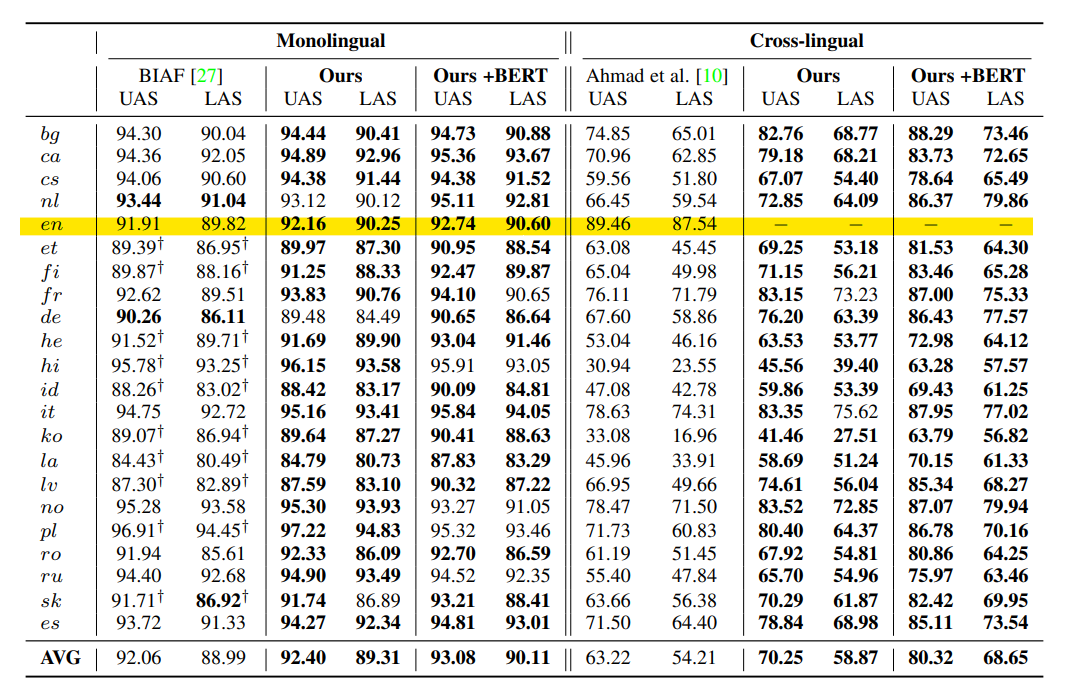

As we can see the performance of this model reach an astonishing 0.9216 on UAS and with BERT 0.9274. \
Our model is really far from SotA results. \
Since there are also model that reaches those results in multilingual approach, as we can see in this leaderboard for multilingual UD treebank:

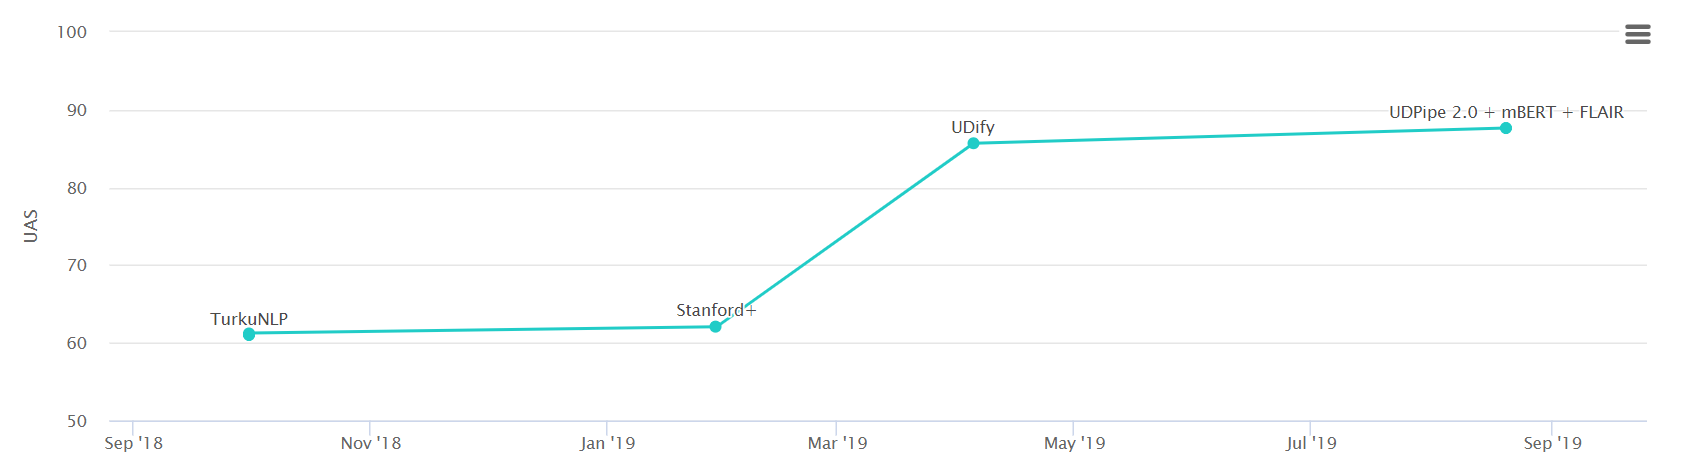